In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time

from scipy.sparse import csr_matrix
from cvxopt.solvers import qp
from cvxopt import spmatrix, matrix, solvers

%matplotlib inline

In [2]:
class build_track:
    def __init__(self,F):
        num=200
        F1=F[0]
        F2=F[1]
        self.Center_X=np.linspace(-F1,1,num)
        self.Center_Y=np.linspace(0,0,num)
        
        self.WL=0.1
        self.WR=0.1
        
        self.Left_X=self.Center_X
        self.Left_Y=np.linspace(1,1,num)*self.WL
        
        self.Right_X=self.Center_X
        self.Right_Y=np.linspace(-1,-1,num)*self.WR
        

In [3]:
class build_path:
    def __init__(self,F,P,T):
        F1=F[0]
        F2=F[1]
        self.PX=np.array([-F1,0,F2,1])
        self.PY=P*T.WL
        self.S=np.array([0,F1,F1+F2,F1+1])
        self.WL=T.WL
        self.WR=T.WR
        
        self.len=F1+1
        self.Vx=0.01
        self.Np=int(np.floor(self.len/self.Vx))
        self.Ns=2
        self.Nc=1
        Np=self.Np
        Ns=self.Ns
        Nc=self.Nc
        self.X=np.linspace(-F1,1,Np+1)
        

        self.Ac=np.array([[0,1],[0,0] ])
        self.Bc=np.array([[0],[1]])
        self.Ad=np.eye(Ns)+self.Ac
        self.Bd=self.Bc
        
        # parameters of constraints
        self.Q=np.array([0,1])
        self.R=np.array([100.0])
        ind=np.floor(self.S/self.Vx)
        self.ind=np.array([int(i) for i in ind])
        
        # dynamics model      
        A_combined1=np.eye((Np+1)*Ns)
        A_combined2=np.zeros(((Np+1)*Ns,Np*Nc))
#         self.b_qp=np.zeros((Np+1)*Ns)
        
        for index in range(Np):
            ind1=Ns+index*Ns+np.arange(Ns)
            ind2x=index*Ns+np.arange(Ns)
            ind2u=index*Nc+np.arange(Nc)
            
            A_combined1[np.ix_(ind1,ind2x)]=-self.Ad
            A_combined2[np.ix_(ind1,ind2u)]=-self.Bd
        
        self.A_qp=np.hstack((A_combined1,A_combined2))
#         self.b_qp[self.ind*Ns]=self.PY
        
        # boundary constraints
        self.bnd_Y=np.arange(Np+1)*Ns
        
        # weights
        Q_w=np.tile(self.Q,(1,Np+1))
        R_w=np.tile(self.R,(1,Np))
        
        self.Q_qp=np.diag(np.hstack((Q_w,R_w))[0])
        
    #========================================================    
    def generate(self):
        Np=self.Np
        Ns=self.Ns
        Nc=self.Nc
#         w_ay=self.R[0]
        w_ay=5
    
        x=cp.Variable((Ns,Np+1))
        u=cp.Variable((Nc,Np))
        
        cost=cp.norm(x[1,:])+w_ay*cp.norm(u)
        
        constr=[]
        
        constr+=[x[0,self.ind]==self.PY]
        constr+=[x[0,:]>=-np.ones(Np+1)*self.WR, 
                x[0,:]<=np.ones(Np+1)*self.WL]
        
        for t in range(Np):
            constr+=[x[:,t+1]==self.Ad@x[:,t]+self.Bd@u[:,t]]
        
        problem=cp.Problem(cp.Minimize(cost),constr)
        problem.solve()
        
        path.Y=x[0,:].value
        path.Vx=x[1,:].value
        path.ay=u.value
    
    #==============================================================
    def generate_qp(self):
        Np=self.Np
        Ns=self.Ns
        Nc=self.Nc
        
        x=cp.Variable((Np+1)*Ns+Np*Nc)
        
        ind_Y=np.arange(Np+1)*Ns
        ind_Vy=1+np.arange(Np+1)*Ns
        ind_ay=(Np+1)*Ns+np.arange(Np)*Nc
#         w_ay=self.R[0]
        w_ay=5
        
#         cost=cp.norm(x[ind_Vy])+w_ay*cp.norm(x[ind_ay])
        
        cost= cp.quad_form(x,self.Q_qp)
        
        constraints=[]
        constraints+=[self.A_qp@x==np.zeros((Np+1)*Ns)]
        constraints+=[x[self.ind*Ns]==self.PY]
        constraints+=[x[ind_Y]>=-np.ones(Np+1)*self.WR,
                     x[ind_Y]<=np.ones(Np+1)*self.WL]

        
        prob=cp.Problem(cp.Minimize(cost),constraints)
        prob.solve()
        
        path.Y=x[ind_Y].value
        path.Vy=x[ind_Vy].value
        path.ay=x[ind_ay].value

In [12]:
F=np.array([0.65,0.5])
P=np.array([0.00,-0.8,0.9,-0.8])
track=build_track(F)
path=build_path(F,P,track)


start=time.time()
for i in range(20):
    path.generate_qp()

end=time.time()

print(end-start)

0.784369945526123


(-0.7325, 1.0825, -0.11000000000000001, 0.11000000000000001)

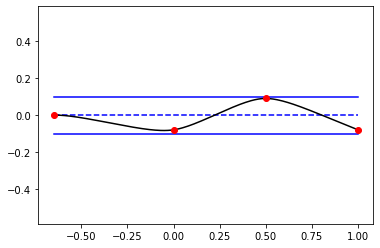

In [11]:
f=plt.figure()

plt.plot(track.Center_X,track.Center_Y,'b--')
plt.plot(track.Left_X,track.Left_Y,'b')
plt.plot(track.Right_X,track.Right_Y,'b')
plt.plot(path.X,path.Y,'k')
plt.plot(path.PX,path.PY,'ro')
# plt.plot(path.X,a,'ro')

plt.axis('equal')